In [288]:
import numpy as np
import random
from enum import Enum, auto
import matplotlib.pyplot as plt
from typing import Tuple
import sys

In [289]:
class Action(Enum) :
    UP = 0
    DOWN = auto()
    LEFT = auto()
    RIGHT = auto()       

In [290]:
class Environment:
    def __init__(self, size = 5):
        self.size = size
        self.goodState1 = [0,1]
        self.goodState2 = [0,3]
        self.goodStates = [self.goodState1,self.goodState2]
        self.toState1 = [4,1]
        self.toState2 = [2,3]
        self.toStates = [self.toState1,self.toState2]
        self.badState1 = [1,1]
        self.badState2 = [4,4]
        self.badStates = [self.badState1,self.badState2]
        

        
    
    # action "right","left","up","down"
    def step(self, state: list, action: Action) -> (list,str):
        reward = 0
        
        # Calculate a new "theoretical" state
        new_state = [sum(x) for x in zip(state,self.getDirectionVector(action))]
        # Check if we are in a good state
        if (state in self.goodStates):
            if state == self.goodState1:
                reward = 10
                new_state = self.toState1
            else:
                reward = 5
                new_state = self.toState2
        # Check if new "theoretical" state is actually a valid state
        elif any(coordinate not in range(0,self.size) for coordinate in new_state):
            # new state is actually illegal
            reward = -1
            new_state = state    
        # Check if we are in a bad state
        elif (state in self.badStates):
            reward = -1
        return new_state,reward
            
        
    # a mapping of directions to vectors     
    def getDirectionVector(self,action: Action) -> list:
        directionVector = [0,0]
        if action == Action.LEFT:
            directionVector = [0,-1]
        elif action == Action.RIGHT:
            directionVector = [0,1]
        elif action == Action.DOWN:
            directionVector = [1,0]
        elif action == Action.UP:
            directionVector = [-1,0]
            
        return directionVector   

In [291]:


#def incementalMean(old_mean,new_value, k):
#    return old_mean + (1/k)*(value-old_mean)

class Policy:
    def __init__(self):
        self._possible_actions = [action for action in Action]
        self._action_probs = np.full((5,5,len(Action)),1/len(Action))

    def __call__(self, state: Tuple[int, int], action: Action) -> float:
        """
        Returns the action probability
        """
        assert action in self._possible_actions
        return self._action_probs[state[0]][state[1]][action.value]
    
    def improve(self, V) -> bool:
        """
        Improves Policy and returns True when stable
        """
        env = Environment()
        policy_stable = True
        for y in range(env.size):
            for x in range(env.size):
                state = [y,x]
                max_q = -sys.maxsize - 1 #min int
                max_a = max(range(len(self._action_probs[y][x])), key=self._action_probs[y][x].__getitem__) #save current best action
                for action in Action:
                    next_state, reward = env.step(state,action)
                    y_next,x_next = next_state
                    q = reward + gamma*V[y_next][x_next]
                    if q > max_q:
                        max_q = q
                        self._action_probs[y,x,] = 0
                        self._action_probs[y][x][action.value] = 1         
                # Check if policy is stable e.g. if any action has changes       
                new_max_a = max(range(len(self._action_probs[y][x])), key=self._action_probs[y][x].__getitem__)
                if max_a != new_max_a:
                    policy_stable = False
        return policy_stable


In [292]:
def vis_policy(V):
    actionMatrix = np.chararray((env.size,env.size),unicode=True)
    arrows = ['↑','↓','←','→']
    for y in range(env.size):
        for x in range(env.size):
            state = [y,x]
            max_action_prob = 0
            max_action = None
            for action in Action:
                action_prob = pi(state,action)
                if action_prob > max_action_prob:
                    max_action_prob = action_prob
                    max_action = action
            actionMatrix[y][x] = arrows[max_action.value]
    
    fig, ax = plt.subplots()
    ax.matshow(V, cmap=plt.cm.Reds)
    for i in range(V.shape[0]):
        for j in range(V.shape[1]):
            c = actionMatrix[j, i]
            ax.text(i,j,c)
                

def vis_matrix(M, cmap=plt.cm.Reds):
    fig, ax = plt.subplots()
    ax.matshow(M, cmap=cmap)
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            c = M[j, i]
            ax.text(i,j, "%.2f" % c, ha='center', va='center')
    

# Policy Iteration

In [293]:
#BartoSutton page 102

env = Environment()
pi = Policy() 
V = np.zeros((env.size,env.size))

error = 0
treshhold = 0.1
eval_iterations = 0
policy_iterations = 0
stable = False
while not stable:
    policy_iterations += 1
    accurate_enough = False
    while not accurate_enough: 
        eval_iterations += 1
        error = 0
        for y in range(env.size):
            for x in range(env.size):
                state = [y,x]
                v = V[y][x]
                v_temp = 0
                for action in Action:
                    next_state, reward = env.step(state,action)
                    y_next,x_next = next_state
                    v_temp += pi(state,action)*(reward + gamma*V[y_next][x_next])
                V[y][x] = v_temp
                error = max(error, v - v_temp)
        if error < treshhold:
            print("Needed iterations for policy evaluation: ", eval_iterations)
            accurate_enough = True
    stable = pi.improve(V)
print("Needed policy improvements in total: ", policy_iterations)

Needed iterations for policy evaluation:  8
Needed iterations for policy evaluation:  9
Needed iterations for policy evaluation:  10
Needed iterations for policy evaluation:  11
Needed iterations for policy evaluation:  12
Needed policy improvements in total:  5


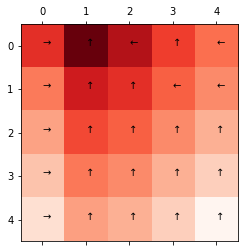

In [294]:
vis_policy(V)

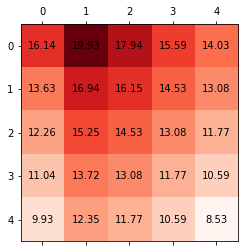

In [295]:
vis_matrix(V)

## Old Code for exhaustive search - what is it called i have done here?

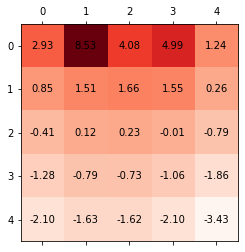

In [296]:
env = Environment()
pi = Policy()
numberOfStates = env.size * env.size
numberOfActions = len(Action)
R = np.zeros((numberOfStates,numberOfStates))
P = np.zeros((numberOfStates,numberOfStates))


for y in range(env.size):
    for x in range(env.size):
        state = [y,x]
        for action in Action:
            next_state, reward = env.step(state,action)
            y_next,x_next = next_state
            R[y*env.size + x][y_next*env.size + x_next] = reward
            P[y*env.size + x][y_next*env.size + x_next] += pi(state,action)

R_e = np.sum(P*R, axis=1, keepdims=True)


# solves equation Ax = B
# (I - yP)V = R_e
gamma = 0.9
A=np.eye(25) - gamma*P
B=R_e
V=np.linalg.solve(A,B)
V = np.reshape(V,(env.size,env.size))

vis_matrix(V)